In [11]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.model_selection import train_test_split

sys.path.append(os.path.abspath(os.path.join('..', 'src')))

from data_loader import load_bearing_data, compute_melspec, creadte_dataset_windows

In [ ]:
DATA_DIR = '../data/raw/2nd_test'
files = sorted(os.listdir(DATA_DIR))

healthy_files = files[0:100]
failure_files = files[-5]

print(f'Loading {len(healthy_files)} data...')

all_windows = []
for filename in healthy_files:
	df = load_bearing_data(filename, DATA_DIR)
	melspec = compute_melspec(df)
	norm_mel = (melspec - (-80)) / (0 - (-80))
	windows = creadte_dataset_windows(norm_mel)
	all_windows.append(windows)

X_train = np.concatenate(all_windows, axis=0)
print(f'Traing data shape: {X_train.shape}')

df_failure = load_bearing_data(failure_files, DATA_DIR)
mel_fail = compute_melspec(df_failure)
norm_fail = (mel_fail - (-80)) / (0 - (-80))
X_test_anomaly = creadte_dataset_windows(norm_fail)

print(f'Anomaly shape: {X_test_anomaly.shape}')

Loading 100 data...
Traing data shape: (400, 128, 64, 1)
Anomaly shape: (4, 128, 64, 1)


In [10]:
def build_autoencoder(input_shape):
	model = models.Sequential()
	model.add(layers.Input(shape=input_shape))
	
	model.add(layers.Conv2D(32, (3,3), activation='relu', padding='same'))
	model.add(layers.MaxPooling2D((2,2), padding='same'))
	model.add(layers.Conv2D(16, (3,3), activation='relu', padding='same'))
	model.add(layers.MaxPooling2D((2,2), padding='same'))
	model.add(layers.Conv2D(8, (3,3), activation='relu', padding='same'))
	model.add(layers.MaxPooling2D((2,2), padding='same'))

	model.add(layers.Conv2D(8, (3,3), activation='relu', padding='same'))
	model.add(layers.UpSampling2D((2,2)))
	model.add(layers.Conv2D(16, (3,3), activation='relu', padding='same'))
	model.add(layers.UpSampling2D((2,2)))
	model.add(layers.Conv2D(32, (3,3), activation='relu', padding='same'))
	model.add(layers.UpSampling2D((2,2)))
	
	model.add(layers.Conv2D(1, (3,3), activation='sigmoid', padding='same'))

	return model

input_shape = (128, 64, 1)
model = build_autoencoder(input_shape)

model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 128, 64, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 32, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 16, 8)      │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 8, 8)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 8, 8)       │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 32, 16, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 32, 16, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 64, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 64, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_4 (UpSampling2D)  │ (None, 128, 64, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 128, 64, 1)     │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,785 (49.94 KB)

 Trainable params: 12,785 (49.94 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
X_train_split, X_val_split = train_test_split(X_train, test_size=0.1, random_state=42)

In [15]:

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min',
    restore_best_weights=True
)

history = model.fit(
    X_train_split, X_train_split, 
    epochs=50,
    batch_size=64,
    validation_data=(X_val_split, X_val_split),
    callbacks=[early_stopping],
    shuffle=True 
)


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - loss: 0.0628 - val_loss: 0.0550
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0447 - val_loss: 0.0184
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0109 - val_loss: 0.0153
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0097 - val_loss: 0.0048
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0064 - val_loss: 0.0061
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0048 - val_loss: 0.0049
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0046 - val_loss: 0.0038
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0039 - val_loss: 0.0038
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0029 - val_loss: 0.0028


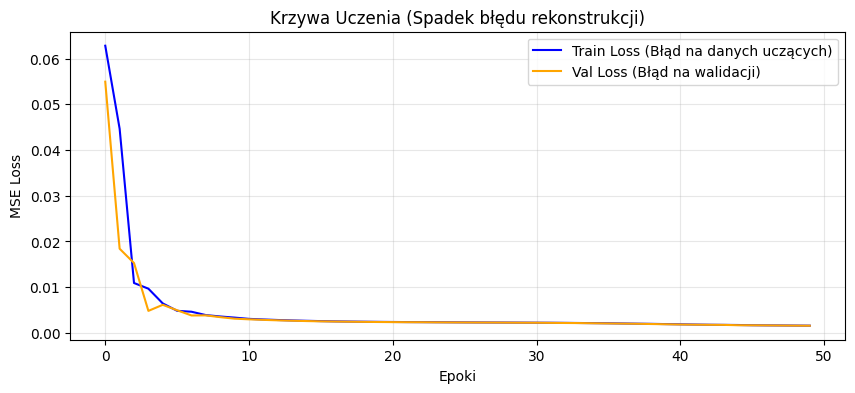

In [16]:
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'],
         label='Train Loss (Błąd na danych uczących)', color='blue')
plt.plot(history.history['val_loss'],
         label='Val Loss (Błąd na walidacji)', color='orange')
plt.title('Krzywa Uczenia (Spadek błędu rekonstrukcji)')
plt.xlabel('Epoki')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()